In [1]:
import pandas as pd
from preprocess import Audio_Processor
import data_utils as du
from sklearn import metrics
from keras.wrappers.scikit_learn import KerasClassifier
from classification_plots import plot_confusion_matrix, plot_learning_curve
import matplotlib.pyplot as plt
import os
import mdn
from sklearn.ensemble import RandomForestClassifier

Using TensorFlow backend.
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
# Able to specify which GPU to use
os.environ["CUDA_VISIBLE_DEVICES"]="2"

SR = 44100
blocksize = 11025
overlap = 5512

In [3]:
import warnings
warnings.filterwarnings('ignore')

# Setup

In [4]:
audio_dir = '../ESC-50/audio/'

In [5]:
path_to_db='../ESC-50/'
ps = Audio_Processor(path_to_db + 'audio/')

# Load Dataset
Here we load the csv that describes each file in the dataset. We add a high level category that is defined in the ESC-50 documentation. This we realize is anthetical to true training, it is a stopgap for when we use NLP to classify tags into these categories.

In [6]:
dataset = pd.read_csv(path_to_db + 'meta/esc50.csv')
classes = [None] * 50
h_classes = ['Human & Animal', 'Interacting Materials']

In [7]:
mapping = {
    'dog': 0,
    'rooster': 0,
    'pig': 0,
    'cow': 0,
    'frog': 0,
    'cat': 0,
    'hen': 0,
    'insects': 0,
    'sheep': 0,
    'crow': 0,
    'rain': 1,
    'sea_waves': 1,
    'crackling_fire': 1,
    'crickets': 0,
    'chirping_birds': 0,
    'water_drops': 1,
    'wind': 1,
    'pouring_water': 1,
    'toilet_flush': 1,
    'thunderstorm': 1,
    'crying_baby': 0,
    'sneezing': 0,
    'clapping': 0,
    'breathing': 0,
    'coughing': 0,
    'footsteps': 1,
    'laughing': 0,
    'brushing_teeth': 1,
    'snoring': 0,
    'drinking_sipping': 1,
    'door_wood_knock': 1,
    'mouse_click': 1,
    'keyboard_typing': 1,
    'door_wood_creaks': 1,
    'can_opening': 1,
    'washing_machine': 1,
    'vacuum_cleaner': 1,
    'clock_alarm': 1,
    'clock_tick': 1,
    'glass_breaking':1 ,
    'helicopter': 1,
    'chainsaw': 1,
    'siren': 1,
    'car_horn': 1,
    'engine': 1,
    'train': 1,
    'church_bells': 1,
    'airplane': 1,
    'fireworks': 1,
    'hand_saw': 1,
}

In [8]:
dataset['h_category'] = None
for index, row in dataset.iterrows():
    target = row['target']
    classes[target] = row['category']
    dataset.loc[index, 'h_category'] = mapping[row['category']]

In [9]:
dataset.head()

,filename,fold,target,category,esc10,src_file,take,h_category
0,1-100032-A-0.wav,1,0,dog,True,100032,A,0
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A,0
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A,1
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B,1
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A,1


## Getting Preprocessed Data
We allow for previously preprocessed data to be retrieved for faster training turnaround. If the fold has been preprocessed, it is loaded but if not it is processed and saved.

In [10]:
import time
import librosa
import numpy as np
import soundfile as sf

def load_fold_audio_blockwise(fld, data, blocksize=1024, overlap=512, debug=False):
    start_time = time.time()
    f_df = data[data['fold'] == fld]
    items = []
    h_cat = []
    cat = []
    for i, sample in f_df.iterrows():
        if debug:
            print("File Processing", end="", flush=True)
        blockgen = sf.blocks(audio_dir + sample['filename'], 
                             blocksize=blocksize, 
                             overlap=overlap, 
                             always_2d=True, 
                             fill_value=0.0)
        SR = sf.info(audio_dir + sample['filename']).samplerate
        for bl in blockgen:
            if not np.any(bl):
                continue
            if debug:
                print(".", end="", flush=True)
            y = bl.transpose()
            y = y[:int(blocksize)]
            y = y[np.newaxis, :]
            items.append(y)
            h_cat.append(sample.h_category)
            cat.append(sample.target)
        if debug:
            print("Done")

    print("\tProcessing Time: " + str(time.time() - start_time))
    return np.vstack(items), np.array(h_cat), np.array(cat)

def load_audio_blockwise(data, blocksize=1024, overlap=512, debug=False):
    start_time = time.time()
    items = []
    target = []
    for i, sample in data.iterrows():
        if debug:
            print("File Processing", end="", flush=True)
        blockgen = sf.blocks(audio_dir + sample['filename'], 
                             blocksize=blocksize, 
                             overlap=overlap, 
                             always_2d=True, 
                             fill_value=0.0)
        sr = sf.info(audio_dir + sample['filename']).samplerate
        for bl in blockgen:
            if not np.any(bl):
                continue
            if debug:
                print(".", end="", flush=True)
            y = bl.transpose()
            y = y[:int(blocksize)]
            y = y[np.newaxis, :]
            items.append(y)
            target.append(sample.h_category)
        if debug:
            print("Done")
    print("\tProcessing Time: " + str(time.time() - start_time))
    return np.vstack(items), np.array(target)

In [11]:
c_data, targets, c_targets = load_fold_audio_blockwise(1, dataset, blocksize, overlap)
# c_data, targets = load_fold_audio(1, dataset)
print(c_data.shape)

	Processing Time: 7.223806619644165
(14019, 1, 11025)


In [12]:
a_data = c_data[targets == 0]
a_targ = c_targets[targets == 0]
i_data = c_data[targets == 1]
i_targ = c_targets[targets == 1]

In [13]:
names_a = []
for name in np.unique(a_targ):
    names_a.append(classes[name])
names_i = []
for name in np.unique(i_targ):
    names_i.append(classes[name])
print(names_a)
print(names_i)

['dog', 'rooster', 'pig', 'cow', 'frog', 'cat', 'hen', 'insects', 'sheep', 'crow', 'crickets', 'chirping_birds', 'crying_baby', 'sneezing', 'clapping', 'breathing', 'coughing', 'laughing', 'snoring']
['rain', 'sea_waves', 'crackling_fire', 'water_drops', 'wind', 'pouring_water', 'toilet_flush', 'thunderstorm', 'footsteps', 'brushing_teeth', 'drinking_sipping', 'door_wood_knock', 'mouse_click', 'keyboard_typing', 'door_wood_creaks', 'can_opening', 'washing_machine', 'vacuum_cleaner', 'clock_alarm', 'clock_tick', 'glass_breaking', 'helicopter', 'chainsaw', 'siren', 'car_horn', 'engine', 'train', 'church_bells', 'airplane', 'fireworks', 'hand_saw']


In [14]:
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(
                        c_data, targets, test_size=0.20, random_state=42)

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import keras
import kapre
from datetime import datetime
now = datetime.now()
import librosa
from librosa import display

def check_model(model):
    model.summary(line_length=80, positions=[.33, .65, .8, 1.])

    batch_input_shape = (2,) + model.input_shape[1:]
    batch_output_shape = (2,) + model.output_shape[1:]
    model.compile('sgd', 'mse')
    model.fit(np.random.uniform(size=batch_input_shape), np.random.uniform(size=batch_output_shape), epochs=1)

def visualise_model(model, src, logam=False):
    n_ch, nsp_src = model.input_shape[1:]
    print(src.shape)
    src = src[:nsp_src]
    src_batch = src[np.newaxis, :]
    pred = model.predict(x=src_batch)
    if keras.backend.image_data_format == 'channels_first':
        result = pred[0, 0]
    else:
        result = pred[0, :, :, 0]
    display.specshow(result, y_axis='linear', fmin=800, fmax=8000, sr=SR)
    plt.show()
    
def evaluate_model(model, c_data):
    pred = model.predict(x=c_data)
    if keras.backend.image_data_format == 'channels_first':
        result = pred[0, 0]
    else:
        result = pred[:, :, :, 0]
#     result = np.swapaxes(result, 1, 2)
    print(result.shape)
    return result

________________________________________________________________________________
Layer (type)              Output Shape              Param #     
melspectrogram_1 (Melspec (None, 128, 44, 1)        296064      
Total params: 296,064
Trainable params: 0
Non-trainable params: 296,064
________________________________________________________________________________
Epoch 1/1
2/2 [==============================] - 7s 3s/step - loss: 1416.2087
(1, 11025)


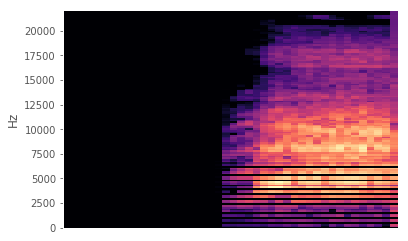

(14019, 128, 44)
________________________________________________________________________________
Layer (type)              Output Shape              Param #     
spectrogram_1 (Spectrogra (None, 257, 44, 1)        263168      
Total params: 263,168
Trainable params: 0
Non-trainable params: 263,168
________________________________________________________________________________
Epoch 1/1
2/2 [==============================] - 0s 83ms/step - loss: 1171.5688
(1, 11025)


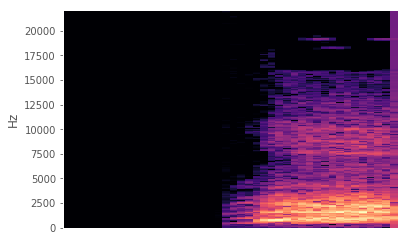

(14019, 257, 44)


In [16]:
import keras
import kapre
from keras.models import Sequential
from kapre.time_frequency import Melspectrogram, Spectrogram
from kapre.filterbank import Filterbank
import numpy as np

model = Sequential()
model.add(Melspectrogram(
    sr=44100,
    n_mels=128,
    power_melgram=2.0,
    return_decibel_melgram = True,
    input_shape=(1, blocksize),
    trainable_fb=False
))

check_model(model)
visualise_model(model, c_data[1])
mfccs = evaluate_model(model, c_data)

model = Sequential()
model.add(Spectrogram(
    return_decibel_spectrogram = True,
    input_shape=(1, blocksize)
))

check_model(model)
visualise_model(model, c_data[1])
spec = evaluate_model(model, c_data)

# Deep Net
Separate into classes

In [17]:
import librosa

def preprocess(mel_spec, spec):
    # Calculate the first 13 mfcc's
    mfccs = librosa.feature.mfcc(S=mel_spec, n_mfcc=13)
    # Get first derivative of the mfccs
    delta = librosa.feature.delta(mfccs)
    # Get second derivative of mfccs
    delta_2 = librosa.feature.delta(mfccs, order=2)
    
    spec_contrast = librosa.feature.spectral_contrast(S=spec)
    
    return np.vstack((mfccs[1:], delta, delta_2, spec_contrast)).transpose()

In [18]:
a_mfcc = mfccs[targets == 0]
a_spec = spec[targets == 0]
a_targ = c_targets[targets == 0]
i_mfcc = mfccs[targets == 1]
i_spec = spec[targets == 1]
i_targ = c_targets[targets == 1]

In [19]:
start_time = time.time()

new_dat = []
for i in range(0, a_spec.shape[0]):
    new_dat.append(preprocess(a_mfcc[i], a_spec[i]))

print(new_dat[0].shape)
print("\tProcessing Time: " + str(time.time() - start_time))

(44, 45)
	Processing Time: 38.72954821586609


In [20]:
new_dat = np.average(new_dat, axis=1)
print(new_dat.shape)

(5171, 45)


In [21]:
new_dat = np.vstack(new_dat)
print(new_dat.shape)

(5171, 45)


In [22]:
print(a_targ.shape)

(5171,)


# Animal Sounds

In [23]:
train_X, test_X, train_y, test_y = train_test_split(
                        new_dat, a_targ, test_size=0.20, random_state=56)

In [24]:
from keras.layers import Dense, Dropout

def gpu_mfcc_deep_net_a():
    # Create Model
    model = Sequential()
    model.add(Dense(128, activation='relu', input_shape=(45,)))
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(19, kernel_initializer='normal', activation='softmax'))
    
    # Compile model
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    
    model.summary()

    
    return model

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Paralle

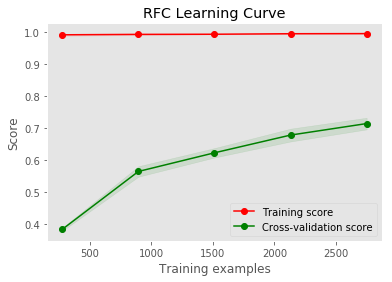

In [25]:
anim = RandomForestClassifier(verbose=True)
plot_learning_curve(anim, 'RFC Learning Curve', train_X, train_y).show()

In [26]:
anim.fit(train_X, train_y)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.7s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=True,
            warm_start=False)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


0.7420289855072464
Confusion matrix, without normalization
[[44  0  0  3  0  0  1  0  0  0  0  0  1  3  0  0  0  1  0]
 [ 2 22  1  2  2  1  2  0  0  6  0  0  1  2  1  0  0  0  0]
 [ 0  0 55  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 5  1  1 39  1  5  2  0  0  0  0  0  1  3  2  0  1  2  1]
 [ 0  0  0  4 43  0  1  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  3  0  1 38  0  0  0  1  0  0  2  2  1  0  0  0  1]
 [ 3  0  0  2  0  2 43  1  2  0  0  0  0  0  0  1  2  0  0]
 [ 0  0  0  0  0  0  1 45  1  0  0  0  0  0  0  0  0  0  1]
 [ 1  0  7  2  3  1  4  0 58  0  0  0  0  0  0  1  0  1  0]
 [ 2  0  1  0  0  3  0  2  1 49  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 72  0  0  0  0  0  0  0  1]
 [ 1  0  0  0  0  0  0  0  1  1  1 53  3  0  0  0  0  1  1]
 [ 1  1  2  1  2  3  6  0  1  2  0  1 32  1  0  0  2  2  2]
 [ 2  2  0  3  1  1  0  0  0  0  2  2  0 11  0  0  1  2  2]
 [ 0  0  0  1  1  0  1  0  0  1  0  0  0  0 54  0  0  0  0]
 [ 0  0  5  0  1  1  1  0  1  0  0  0  0 

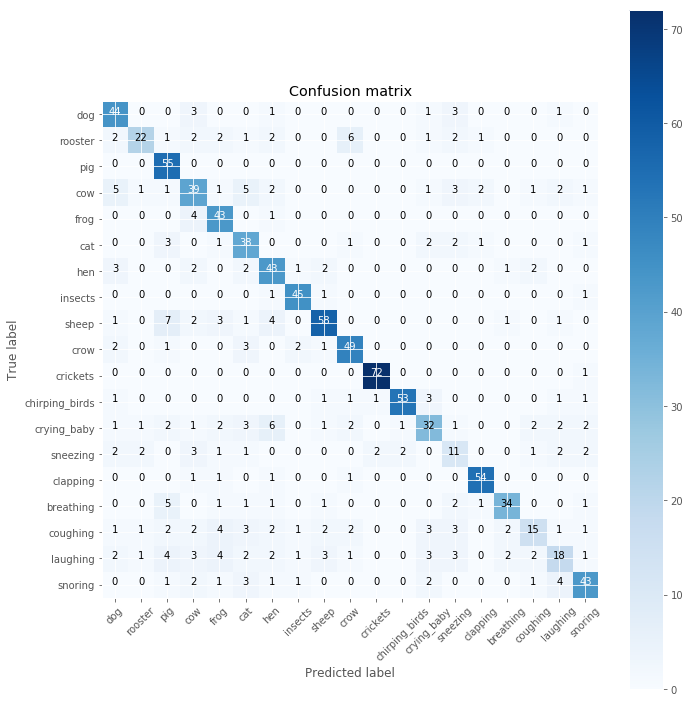

In [27]:
pred = anim.predict(test_X)
print(metrics.accuracy_score(test_y, pred))
cm = metrics.confusion_matrix(test_y, pred)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, names_a)
plt.show()

# Interacting Materials

In [28]:
start_time = time.time()

new_dat = []
for i in range(0, i_spec.shape[0]):
    new_dat.append(preprocess(i_mfcc[i], i_spec[i]))

print(new_dat[0].shape)
print("\tProcessing Time: " + str(time.time() - start_time))

(44, 45)
	Processing Time: 62.88180589675903


In [29]:
new_dat = np.average(new_dat, axis=1)
print(new_dat.shape)

(8848, 45)


In [30]:
print(i_targ.shape)

(8848,)


In [31]:
train_X, test_X, train_y, test_y = train_test_split(
                        new_dat, i_targ, test_size=0.20, random_state=75)

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Paralle

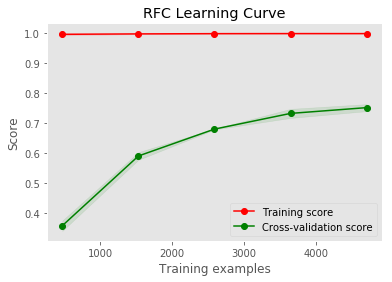

In [32]:
inter = RandomForestClassifier(verbose=True)
plot_learning_curve(inter, 'RFC Learning Curve', train_X, train_y).show()

In [34]:
inter.fit(train_X, train_y)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.2s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=True,
            warm_start=False)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


0.7977401129943503
Confusion matrix, without normalization
[[54  1  0  0  1  0  1  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0]
 [ 0 62  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0]
 [ 0  0 55  0  0  2  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0]
 [ 0  0  0 38  0  0  0  0  0  1  0  2  2  0  1  0  0  0  1  0  0  0  0  0
   0  0  0  0  0  1  0]
 [ 0  0  0  1 67  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0
   0  0  0  0  0  0  0]
 [ 0  1  0  0  0 26  2  0  0  1  2  0  0  4  0  2  0  2  1  0  0  0  0  0
   1  0  0  0  0  0  1]
 [ 0  0  0  0  0  0 42  0  0  0  0  0  0  0  6  0  0  0  1  0  0  0  1  0
   0  1  0  0  0  0  1]
 [ 0  0  0  2  0  1  0 54  0  0  1  1  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  2  0  0  0  0]
 [ 0  0  0  1  0  0  1  0 41  0  0  0  0  2  0  0  0  0  0  1  0  0  1  0
   0  0  0  0  0  4  0]
 [ 2  2  2  1  1  0  4  0  1 46  0  0  0  1  1  0  0  0  1 

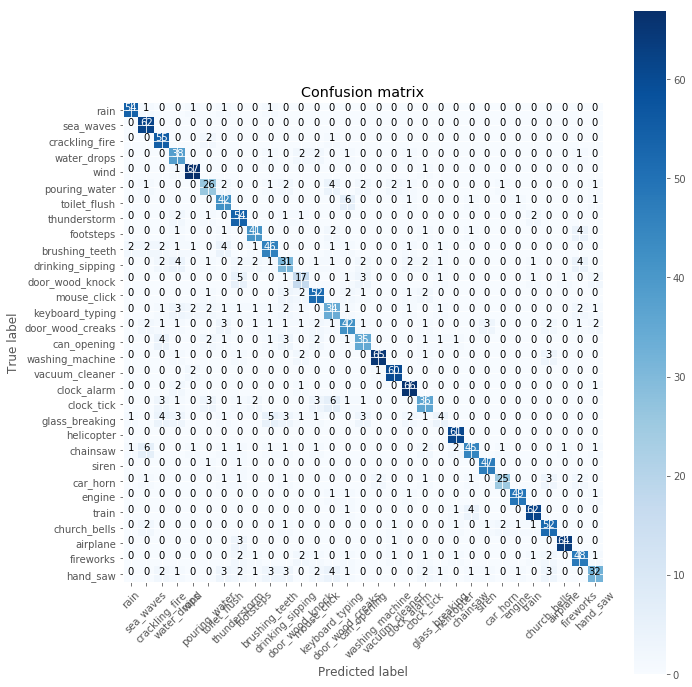

In [35]:
pred = inter.predict(test_X)
print(metrics.accuracy_score(test_y, pred))
cm = metrics.confusion_matrix(test_y, pred)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, names_i)
plt.show()

# All Data

In [36]:
X2, y2, yy2 = load_fold_audio_blockwise(2, dataset, blocksize, overlap)
X3, y3, yy3 = load_fold_audio_blockwise(3, dataset, blocksize, overlap)
X4, y4, yy4 = load_fold_audio_blockwise(4, dataset, blocksize, overlap)
X5, y5, yy5 = load_fold_audio_blockwise(5, dataset, blocksize, overlap)

	Processing Time: 7.999372482299805
	Processing Time: 8.410486221313477
	Processing Time: 7.811376094818115
	Processing Time: 7.754350900650024


In [37]:
X = np.vstack((X2, X3, X4, X5))
print(X.shape)

(56774, 1, 11025)


In [38]:
y = np.concatenate((y2, y3, y4, y5))
print(y.shape)

(56774,)


In [39]:
yy = np.concatenate((yy2, yy3, yy4, yy5))
print(yy.shape)

(56774,)


________________________________________________________________________________
Layer (type)              Output Shape              Param #     
melspectrogram_2 (Melspec (None, 128, 44, 1)        296064      
Total params: 296,064
Trainable params: 0
Non-trainable params: 296,064
________________________________________________________________________________
Epoch 1/1
2/2 [==============================] - 0s 100ms/step - loss: 1418.8026
(1, 11025)


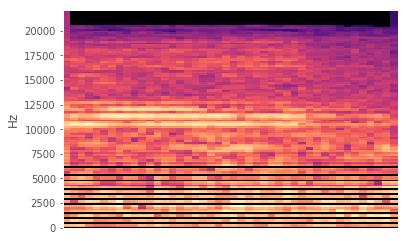

(56774, 128, 44)
________________________________________________________________________________
Layer (type)              Output Shape              Param #     
spectrogram_2 (Spectrogra (None, 257, 44, 1)        263168      
Total params: 263,168
Trainable params: 0
Non-trainable params: 263,168
________________________________________________________________________________
Epoch 1/1
2/2 [==============================] - 0s 91ms/step - loss: 1163.6528
(1, 11025)


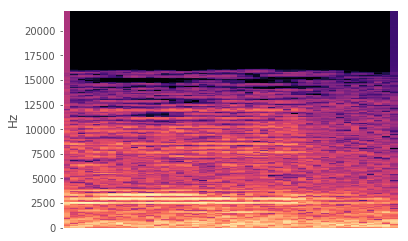

(56774, 257, 44)


In [40]:
model = Sequential()
model.add(Melspectrogram(
    sr=44100,
    n_mels=128,
    power_melgram=2.0,
    return_decibel_melgram = True,
    input_shape=(1, blocksize),
    trainable_fb=False
))

check_model(model)
visualise_model(model, X[1])
mfccs = evaluate_model(model, X)

model = Sequential()
model.add(Spectrogram(
    return_decibel_spectrogram = True,
    input_shape=(1, blocksize)
))

check_model(model)
visualise_model(model, X[1])
spec = evaluate_model(model, X)

In [41]:
a_mfcc = mfccs[y == 0]
a_spec = spec[y == 0]
a_targ = yy[y == 0]
i_mfcc = mfccs[y == 1]
i_spec = spec[y == 1]
i_targ = yy[y == 1]

In [42]:
start_time = time.time()

new_dat = []
for i in range(0, a_spec.shape[0]):
    new_dat.append(preprocess(a_mfcc[i], a_spec[i]))

print(new_dat[0].shape)
print("\tProcessing Time: " + str(time.time() - start_time))

start_time = time.time()

(44, 45)
	Processing Time: 181.0070719718933


In [43]:
new_dat = np.average(new_dat, axis=1)
print(new_dat.shape)

(21104, 45)


In [44]:
print(a_targ.shape)

(21104,)


0.25435936315390445
Confusion matrix, without normalization
[[475  25  13  59  26  44 137  11  25  38   3   8  55  84  16  14  21  32
   21]
 [138 195   9  32  36  16  49  15  29 115   7   8  21 127   8   8  25  28
   19]
 [ 58  16 283  75  26  62  78  77  31  27  10  47 103  11  16  17  20  56
   63]
 [115  22 112 401  58  18 105  15 111  13   1  13  18  25   7  17  12  27
   23]
 [ 61  93  24 123 601  43  31   5  67  11   1  27  39   3  18  15  20  29
   33]
 [151  51  39  83  65  83  79  43  40  63   3  16  63  54  34  31  30  40
   61]
 [159  17  61  87  30  78 280  71  20  22  38  34  92  15  16  39  24  20
   50]
 [ 84   8  29 102  10  31  66 422  32  40  86  98  27  13  12   6   5  13
  127]
 [ 79  40 129  81 100  73  76  47 346  49   2  43  45  15  41  22  13  15
   18]
 [ 63  49  55 113 107  76 110  92 131 207   0  12  37   2  46   4   4  17
   12]
 [ 10  53  15  58  48  55  23  75  30  19 349 368  48   2   8  10   9  27
   41]
 [ 83  18  92  39  47  57  59  70  73  38 128 350

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


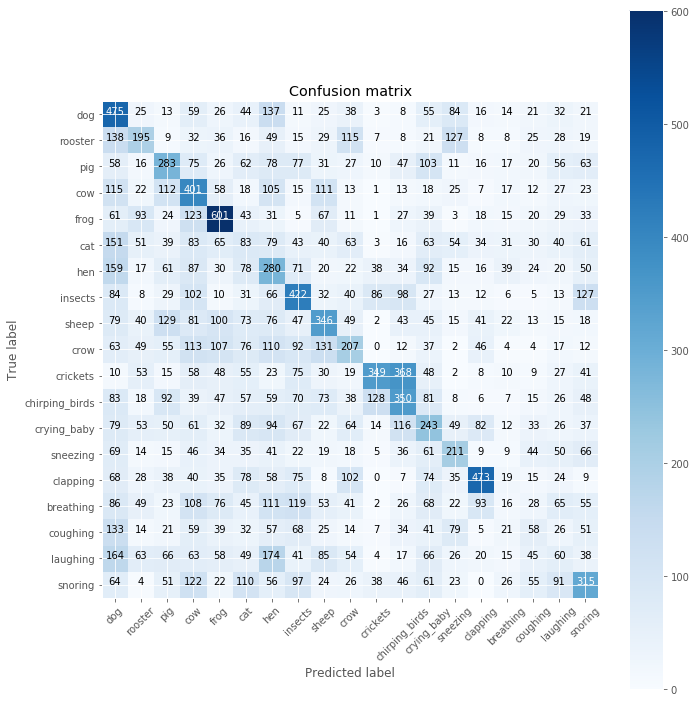

In [45]:
pred = anim.predict(new_dat)
print(metrics.accuracy_score(a_targ, pred))
cm = metrics.confusion_matrix(a_targ, pred)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, names_a)
plt.show()

In [46]:
start_time = time.time()

new_dat = []
for i in range(0, i_spec.shape[0]):
    new_dat.append(preprocess(i_mfcc[i], i_spec[i]))

print(new_dat[0].shape)
print("\tProcessing Time: " + str(time.time() - start_time))

start_time = time.time()

(44, 45)
	Processing Time: 264.51454043388367


In [47]:
new_dat = np.average(new_dat, axis=1)
print(new_dat.shape)

(35670, 45)


In [48]:
print(i_targ.shape)

(35670,)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished


0.18452481076534905
Confusion matrix, without normalization
[[186 124  34   0  33  18  81   4  10  30   5   1   4  12  18  12  94  64
    1   3   5  48 349   0   6  31  35   5  19   0  16]
 [ 71 481   7   9  61   4 110   0  14   8   3   0   1   2  33   3   9  17
    3   8   1  24 269   0  12   5   6  10   3   1  67]
 [  5  12 580  40 123  19  12  24  31  15  33  34  33  61   5  16  15  11
    6  47  20   6   2   0   3   5  17   3   4  27   5]
 [  2   6  78 109  18  70  20  98  48  10 108  34  57  41  54  49   1   0
   27  72  37   3   9  17   2   2   2   1   0  45  12]
 [  1   4  20  22  67   5   9 337   1   0  13  60  15  18  21   4   7   1
    1 111   1  21  48  28  64  32 143 144  26  20   4]
 [ 11  61  82 111  22 236 100  14  29  59  25   6  18  34  64  30   2  11
   66  23  31   2  14  26  22   3   1   3   4  20  51]
 [ 72 123  31  54  31  24 361  18  42  37  26   4  12  32  26   9  30  61
    4  17  14   4  90   1  11   2   5   9   9  29  50]
 [  0   1   9  29  37   7   2 539  22

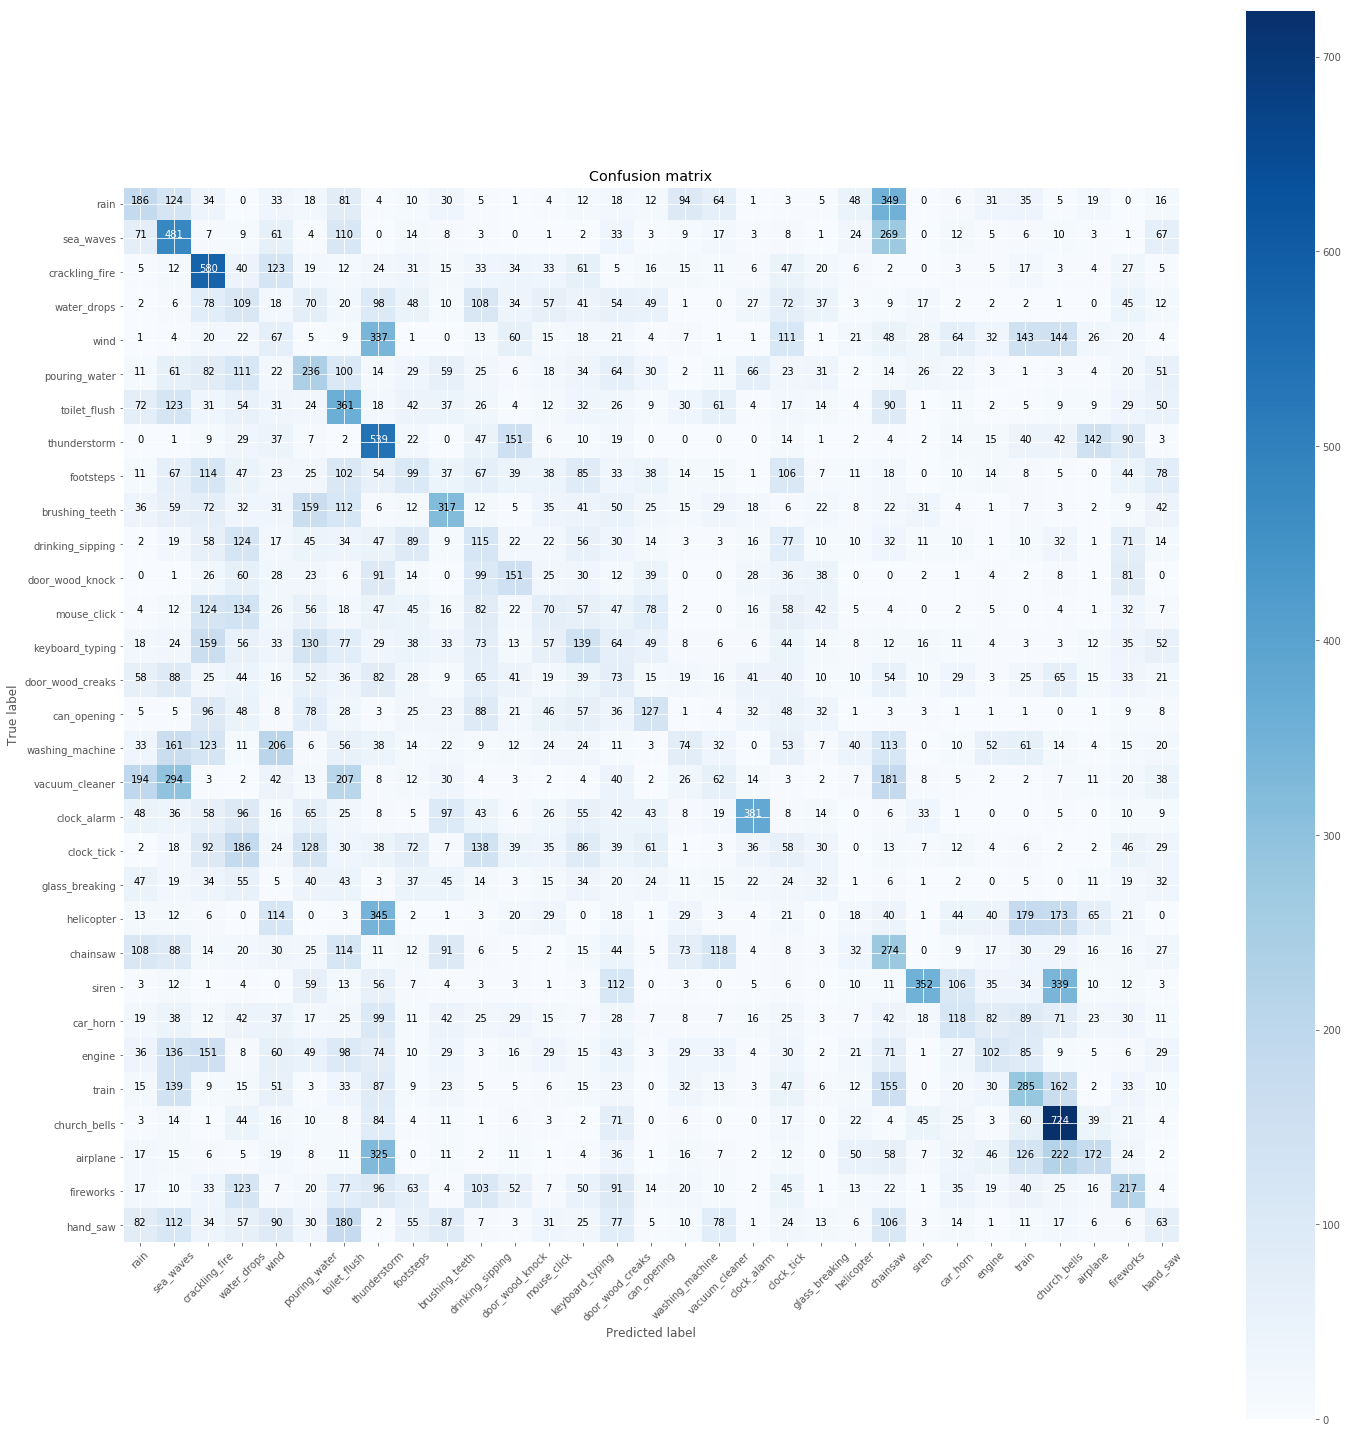

In [49]:
pred = inter.predict(new_dat)
print(metrics.accuracy_score(i_targ, pred))
cm = metrics.confusion_matrix(i_targ, pred)
plt.figure(figsize=(20,20))
plot_confusion_matrix(cm, names_i)
plt.show()